In [1]:
import gym
import numpy as np
import tensorflow as tf
env =  gym.make('FrozenLake8x8-v0')# initialize environment
#env =  gym.make('FrozenLake-v0')# initialize environment


[2016-07-07 10:52:13,148] Making new env: FrozenLake8x8-v0


In [2]:
class tf_RL_model:
    def __init__(self):
        self.action_table = {
            'L' : 0,
            'D' : 1,
            'R' : 2,
            'U' : 3
        }
        self.inv_action_table = {v: k for k, v in self.action_table.items()}
        
        # Learning paramters
        self.learning_rate = 0.1
        self.r_prob = 0.5
        self.r_prob_decay = 0.98

    def epsilon_greedy_action(self,state, eprate):
        if np.random.rand() < self.r_prob:
            action = env.action_space.sample()
        else:
            action = sess.run(optimal_action, feed_dict={batch_state: [state],
                                                        batch_eprate: eprate})[0]
            #action = np.argmax(SV,1)[0]
        return action
    
    def update_parameters(self,oldstate, newstate, action, reward, done, eprate):
        # Get the target values
        
        Qtarget = sess.run(maxQ, 
                     feed_dict = {
                    batch_state : newstate,
                    batch_eprate: eprate
                })#.reshape((batch_size,1))
        
        target = reward + 0.995*Qtarget*(1-done)
        
        #print 'Target:'
        #print target
    
    
        # Update parameters towards the target value
        sess.run(optimizer, 
                 feed_dict = {
                batch_state : oldstate,
                batch_trueQ : target,
                batch_eprate : eprate,
                batch_action : action
            })
        return target
    
    def get_optimal_policy(self):
        optimal = sess.run(optimal_action, feed_dict = {batch_state : range(env.observation_space.n),
                                                        batch_eprate : np.repeat(100,env.observation_space.n).reshape((100, 1))
            })
        optimal_name = [ self.inv_action_table[v] for v in optimal]

        return np.reshape(optimal_name,(np.sqrt(env.observation_space.n), np.sqrt(env.observation_space.n)))
    
    def save_trained_policy(self):
        optimal = sess.run(optimal_action, feed_dict = {batch_state : range(env.observation_space.n)
            })
        trained_policy = {}
        for s in range(env.observation_space.n):
            trained_policy[s] = sess.run(optimal_action, feed_dict = {batch_state : [s]})[0]
        self.trained_policy = trained_policy
        
    def epsilon_decay(self):
        self.r_prob *= self.r_prob_decay
        self.r_prob = np.maximum(0.1,self.r_prob) # Never let random probability be less than 5%

In [3]:
### TF-MODEL SPECIFICATION
model = tf_RL_model()

graph = tf.Graph()
with graph.as_default():
    batch_state = tf.placeholder(tf.int64, shape = ([None,]), name = 'ph_state')
    batch_eprate = tf.placeholder(tf.float32, shape = ([None,]), name = 'ph_eprate')
    batch_action = tf.placeholder(tf.int64, shape = ([None,]), name = 'ph_action')
    batch_reward = tf.placeholder(tf.float32, shape = ([None,]), name = 'ph_reward')
    batch_trueQ = tf.placeholder(tf.float32, shape = ([None,]), name = 'ph_trueQ')
    
    
    #W = tf.Variable(tf.constant(value = np.linspace(start = 1, stop = env.observation_space.n*env.action_space.n, 
    #                                                num = env.observation_space.n*env.action_space.n, dtype='float32'), 
    #                shape = [env.observation_space.n, env.action_space.n]
    #               ))
    
    
    # One hot vectors of state and action indicies:
                        
    state = tf.one_hot(indices = batch_state,
                           depth = env.observation_space.n,
                       on_value = 1.0, off_value = 0.0)
    
    eprateTF = tf.reshape(batch_eprate,[-1,1])
    
    superstate = tf.concat(1,[eprateTF, state])
    hsize = 80
    W1 = tf.get_variable(shape = [env.observation_space.n + 1, hsize],
        initializer = tf.random_normal_initializer(mean=0, stddev= 0.1) , name = 'W1')  
    

    hidden = tf.nn.relu(tf.matmul(superstate,W1))
    
    W2 = tf.get_variable(shape = [hsize, env.action_space.n],
        initializer = tf.random_normal_initializer(mean=0, stddev= 0.1) , name = 'W2')
    
    Qval = tf.matmul(hidden,W2)

    
    action = tf.one_hot(indices = batch_action,
                           depth = env.action_space.n,
                          on_value = 1.0, off_value = 0.0)
    
    optimal_action = tf.argmax(Qval,1)
    maxQ = tf.reduce_max(Qval,1)
    
    mQ = tf.mul(Qval, action)
    Q_a = tf.reduce_sum(mQ,1) # only get non-zero chosen actions
    loss = tf.nn.l2_loss( batch_trueQ - Q_a)
    optimizer = tf.train.GradientDescentOptimizer(model.learning_rate).minimize(loss)
    saver = tf.train.Saver()

In [ ]:
sess = tf.InteractiveSession(graph=graph)
sess.run(tf.initialize_all_variables())
#saver.restore(sess, 'tf-frozen8x8.ckpt')


train_dict1 = {batch_state : [2.0,3], batch_eprate: [0.1, 0.1], batch_action : [1,2]}
train_dict2 = {batch_state : [3.0,3], batch_eprate: [0.1, 0.1], batch_action : [1,2]}


#model.update_parameters()

#sess.run(superstate, feed_dict = train_dict)#.shape
v1 =  sess.run(Q_a, feed_dict= train_dict1)#.shape
print v1
print '---------------------------------------------------------'
v2 = sess.run(Q_a, feed_dict= train_dict2) #.shape
print v2
print '--- IS EQUAL ----'
v1 == v2

In [4]:
sess = tf.Session(graph=graph)


mem_size = 500
replay_memory = np.zeros([mem_size,6])
batch_size = 10

with sess as session:
    sess.run(tf.initialize_all_variables())

    # Probability of random action
    #
    model.r_prob_decay = 0.999992
    model.learning_rate = 0.003
    num_episodes = 500000 # Total number of games

    # Logging variables
    visits = np.zeros([env.observation_space.n])

    run_reward = [] # running average initialize
    #old_optimal = model.get_optimal_policy() # Initial optimal strategy
    
    newweight = sess.run(tf.trainable_variables())[0]
    for n in xrange(num_episodes + 1):
        newstate = env.reset()
        done = False
        
        ### WALK AROUND ###
        maxsteps = 200
        for ep in xrange(maxsteps):
            
            eprate = ep/maxsteps
            oldstate = newstate
            action = model.epsilon_greedy_action(oldstate, [eprate]) # Perform epsilon-greedy action:
            newstate, reward, done, info = env.step(action) # Take action and observe state and reward
            visits[newstate] += 1

            # Reward modifications:
            # if (done is True and reward == 0):
            #    reward = -0.2
            # reward -= 0.01 # cost of life
            
            # Save transition: 
            replay_memory[np.random.choice(mem_size),:] = oldstate, newstate, action, reward, done, eprate
            
            # Debugging:
            if False and reward == 1.0:
                oldweight = newweight
                newweight = sess.run(tf.trainable_variables())[0]
                diff = newweight - oldweight
                print 'old: ' + str(oldstate) + '\t new: ' + str(newstate) +\
                '\t a: ' + str(action) + '\t r: ' + str(reward) +\
                '\t targetQ: ' + str(np.round(tQ[0],3)) + '\t Qval: ' + str(np.round(oldweight[oldstate,action],3)) + '\t Qdiff: ' + str(np.round(diff[oldstate,action],3))                         
            if done:
                break
            
        model.epsilon_decay()
        run_reward.append(reward)
        
        ### UPDATE PARAMETERS ###
        if n > 1:
            train_array = replay_memory[np.random.choice(mem_size, size = batch_size),:]
            tQ = model.update_parameters(            
                oldstate = train_array[:,0],#.reshape((batch_size,1)), 
                                         newstate = train_array[:,1],#.reshape((batch_size,1)), 
                                         action   = train_array[:,2],#.reshape((batch_size,1)), 
                                         reward   = train_array[:,3],#.reshape((batch_size,1)),
                                         done     = train_array[:,4],#.reshape((batch_size,1)), 
                                         eprate   = train_array[:,5] #.reshape((batch_size,1))
                             ) 

            # print 'episode ' + str(n) + 'reached maximum steps. skipping...'



        if n % int(num_episodes/10) == 0:
            run_avg = np.mean(run_reward)
            run_reward = []
            print 'step: ' + str(n) + ' \t r_prob:' + str(np.round(model.r_prob,2)) + '\t run_avg: ' + str(np.round(run_avg,3))
            #print model.get_optimal_policy()
            #print sess.run(tf.trainable_variables())#[0]
    # model.save_trained_policy()
    save_path = saver.save(sess, 'tf-frozen8x8.ckpt')

step: 0 	 r_prob:0.5	 run_avg: 0.0
step: 50000 	 r_prob:0.34	 run_avg: 0.051
step: 100000 	 r_prob:0.22	 run_avg: 0.14
step: 150000 	 r_prob:0.15	 run_avg: 0.267
step: 200000 	 r_prob:0.1	 run_avg: 0.402
step: 250000 	 r_prob:0.1	 run_avg: 0.469
step: 300000 	 r_prob:0.1	 run_avg: 0.475
step: 350000 	 r_prob:0.1	 run_avg: 0.47
step: 400000 	 r_prob:0.1	 run_avg: 0.469
step: 450000 	 r_prob:0.1	 run_avg: 0.476
step: 500000 	 r_prob:0.1	 run_avg: 0.473


0.47304


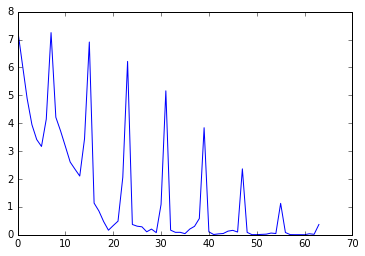

In [5]:
print run_avg
import matplotlib.pyplot as plt
%matplotlib inline

# Number of visits per episode:
plt.plot(visits/num_episodes)
#num_episodes/visits

### Test Run

In [ ]:
sess = tf.InteractiveSession(graph=graph)
saver.restore(sess, 'tf-frozen8x8.ckpt')


env.monitor.start('recordings', force=True)
num_episodes = 10000
R = []


def moving_average(a, n = 100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


model.r_prob = 0 # ensure that only the optimal solution is used

for n in xrange(num_episodes):
    newstate = env.reset()
    done = False
    
    for ep in xrange(200):
        # Current state
        oldstate = newstate
        
        # Perform epsilon-greedy action:
        eprate = ep/200.0
        action = model.epsilon_greedy_action(oldstate, [eprate])
        #action = passive_policy[oldstate]
        # Take action and observe state and reward
        newstate, reward, done, info = env.step(action)
        
        if done:
            break
    R.append(reward)
    if False and reward != 1.0:
        print 'Episode: ' + str(n) +'\t steps: ' + str(ep) + '\t state: ' + str(newstate), '\t reward: ' + str(reward)
    #if n % 1000 == 101:
    #    MA = np.max(moving_average(R))
    #    print 'step: ' + str(n) + '\t MRA: ' + str(MA)
    #    if MA > 0.99:
    #        break
env.monitor.close()

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f0b376ee650>> ignored
[2016-07-08 06:43:54,964] Clearing 22 monitor files from previous run (because force=True was provided)
[2016-07-08 06:43:54,968] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.1.23456.video000000.json
[2016-07-08 06:43:55,158] Ending episode 1 because it reached the timestep limit of 200.
[2016-07-08 06:43:55,161] Starting new video recorder writing to /notebooks/hjem/RL/recordings/openaigym.video.1.23456.video000001.json
[2016-07-08 06:43:55,375] Ending episode 3 because it reached the timestep limit of 200.
[2016-07-08 06:43:55,538] Ending episode 4 because it reached the timestep limit of 200.
[2016-07-08 06:43:55,699] Ending episode 5 because it reached the timestep limit of 200.
[2016-07-08 06:43:55,864] Ending episode 6 because it reached the timestep limit of 200.
[

0.19


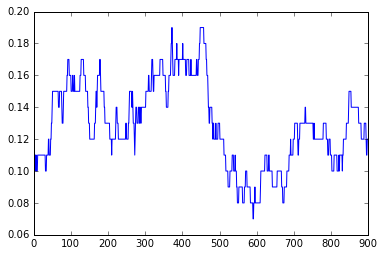

In [7]:
MV = moving_average(R, n = 100)
print np.max(MV)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(MV)

In [ ]:
gym.upload('/notebooks/hjem/RL/recordings', api_key='sk_znZbtlUTlu1nJNqFLRIyA')

In [ ]:
env.monitor.close()
